In [1]:
import os
import shutil
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet101V2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Directories
DATA_DIR = r"C:\Users\farah\Desktop\modelsRun\archive" 
TRAIN_DIR = r"C:\Users\farah\Desktop\modelsRun\train_data2"
TEST_DIR = r"C:\Users\farah\Desktop\modelsRun\test_data2"
IMG_SIZE = (224, 224)  # DenseNet requirement
BATCH_SIZE = 16
EPOCHS = 10
MAX_IMAGES_PER_CLASS = 16000


In [3]:
def prepare_dataset(data_dir, train_dir, test_dir, max_images_per_class, train_split=0.8):
    for dir_path in [train_dir, test_dir]:
        if os.path.exists(dir_path):
            shutil.rmtree(dir_path)
        os.makedirs(dir_path, exist_ok=True)

    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        if os.path.isdir(class_path):
            images = os.listdir(class_path)[:max_images_per_class]
            train_images, test_images = train_test_split(images, train_size=train_split, random_state=42)

            train_class_dir = os.path.join(train_dir, class_name)
            test_class_dir = os.path.join(test_dir, class_name)
            os.makedirs(train_class_dir, exist_ok=True)
            os.makedirs(test_class_dir, exist_ok=True)

            for image in train_images:
                shutil.copy(os.path.join(class_path, image), os.path.join(train_class_dir, image))
            for image in test_images:
                shutil.copy(os.path.join(class_path, image), os.path.join(test_class_dir, image))

In [4]:
prepare_dataset(DATA_DIR, TRAIN_DIR, TEST_DIR, MAX_IMAGES_PER_CLASS)

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_gen = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_gen = datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 46664 images belonging to 4 classes.
Found 11667 images belonging to 4 classes.


In [5]:
# Load ResNet101V2 base model
base_model = ResNet101V2(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))

# Fine-tune layers
for layer in base_model.layers[:-20]:  # Freeze all but the last 20 layers
    layer.trainable = False

171317808/171317808 ━━━━━━━━━━━━━━━━━━━━ 1231s 7us/step


In [6]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.4)(x)


In [7]:
predictions = Dense(train_gen.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [8]:

checkpoint = ModelCheckpoint(
    filepath=os.path.join(r"C:\Users\farah\Desktop\modelsRun", "ResNet101V2_model_epoch_{epoch:02d}.keras"),
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)
csv_logger = CSVLogger(os.path.join(r"C:\Users\farah\Desktop\modelsRun", 'ResNet101V2_training_log.csv'))
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1,
    min_lr=1e-6
)

history = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=EPOCHS,
    callbacks=[checkpoint, csv_logger, lr_scheduler]
)

c:\Users\farah\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 5369s 2s/step - accuracy: 0.6966 - loss: 7.0010 - val_accuracy: 0.8516 - val_loss: 0.9969 - learning_rate: 1.0000e-04
Epoch 2/10
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 5185s 2s/step - accuracy: 0.8388 - loss: 0.8125 - val_accuracy: 0.8736 - val_loss: 0.4418 - learning_rate: 1.0000e-04
Epoch 3/10
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 5132s 2s/step - accuracy: 0.8622 - loss: 0.4576 - val_accuracy: 0.8930 - val_loss: 0.3504 - learning_rate: 1.0000e-04
Epoch 4/10
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 5160s 2s/step - accuracy: 0.8818 - loss: 0.3842 - val_accuracy: 0.8992 - val_loss: 0.3284 - learning_rate: 1.0000e-04
Epoch 5/10
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 5155s 2s/step - accuracy: 0.8930 - loss: 0.3463 - val_accuracy: 0.9021 - val_loss: 0.3232 - learning_rate: 1.0000e-04
Epoch 6/10
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 5128s 2s/step - accuracy: 0.9038 - loss: 0.3157 - val_accuracy: 0.9053 - val_loss: 0.3064 - learning_rate: 1.0000e-04
Epoch 7/10
2917/2917 ━━━━━━━━━━━━━━━━━━━

730/730 ━━━━━━━━━━━━━━━━━━━━ 936s 1s/step - accuracy: 0.8721 - loss: 0.4162
ResNet101V2 Test Accuracy: 0.92
730/730 ━━━━━━━━━━━━━━━━━━━━ 953s 1s/step


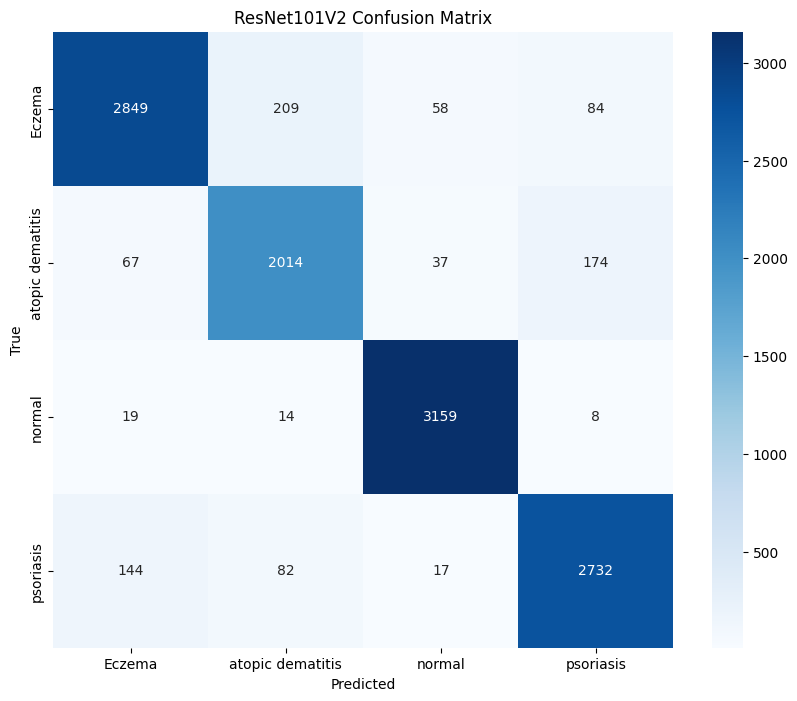

                  precision    recall  f1-score   support

          Eczema       0.93      0.89      0.91      3200
atopic dematitis       0.87      0.88      0.87      2292
          normal       0.97      0.99      0.98      3200
       psoriasis       0.91      0.92      0.91      2975

        accuracy                           0.92     11667
       macro avg       0.92      0.92      0.92     11667
    weighted avg       0.92      0.92      0.92     11667



In [9]:
model.save(os.path.join(r"C:\Users\farah\Desktop\modelsRun", "ResNet101V2_final_model.keras"))

test_gen.reset()
test_loss, test_accuracy = model.evaluate(test_gen)
print(f"ResNet101V2 Test Accuracy: {test_accuracy:.2f}")

test_gen.reset()
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
y_true = test_gen.classes
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=train_gen.class_indices.keys(), yticklabels=train_gen.class_indices.keys())
plt.title("ResNet101V2 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print(classification_report(y_true, y_pred, target_names=train_gen.class_indices.keys()))
